# 1. Libraries, global constants and settings

In [80]:
# standard imports
import gc  # used to manage memory by automatically reclaiming memory occupied by objects that are no longer in use
import itertools
import math  # used for mathematical operations
import random  # used for generating random numbers
import socket  # used for network-related operations, possibly for handling IP addresses
import struct  # used for network-related operations, possibly for handling IP addresses
import time  # used for timing
from typing import *  # type hinting, helps with code readability and error checking
import warnings

# installed imports
import category_encoders as ce  # for encoding categorical variables into numerical variables
import dgl  # deep graph library, used for neural networks
import dgl.function as fn  # provides functions specific to graph operations in DGL
from dgl.data import DGLDataset  # deep graph library, used for neural networks
import matplotlib.pyplot as plt  # for plotting graphs
import networkx as nx  # for the creation, manipulation and study of complex networks
import numpy as np  # for numerical operations
import pandas as pd  # for data manipulation and analysis
from pyod.models.cblof import CBLOF  # clasification model
from pyod.models.hbos import HBOS  # clasification model
from pyod.models.pca import PCA  # clasification model
import torch  # ML library used for building and training neural networks, fundamental for operations involving tensors
import torch.nn as nn  # for accessing PyTorch's neural network functionalities, like layers and activation functions
import torch.nn.functional as F  # provides functions like activation functions, loss functions, etc.
import torch.optim as optim
import seaborn as sns
from sklearn import preprocessing  # ML library used for data preprocessing, like feature scaling
from sklearn.ensemble import IsolationForest  # clasification model
from sklearn.model_selection import train_test_split  # to split the data into training and testing sets
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import Normalizer, StandardScaler  # for data normalization and scaling
# import tqdm  
from tqdm import tqdm  # for displaying progress bars for loops


# datata balancing
from imblearn.over_sampling import RandomOverSampler   
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

# xgboost
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier, DMatrix


In [2]:
# global constants
SEED = 13
FILE_NAME = "NF-CSE-CIC-IDS2018-v2.csv"
POURCENTAGE_DATASET_REMAINING = 0.01
TEST_SET_SIZE = 0.3

In [3]:
# hide the warning information
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 2. Functions

## 2.1. Data Plotting Functions

In [4]:
def show_label_distribution(df: pd.DataFrame, label_column_name: str):
    """Display a histogram to show the distribution of the label_column_name in the given DataFrame.
    
    Args:
        df: The DataFrame containing the 'Label' column.
        label_column_name: The name of the column to show the distribution
    """
    # Create the histogram
    plt.hist(df[label_column_name],
             bins=np.arange(len(df[label_column_name].unique()) + 1) - 0.5,
             rwidth=0.8,
             color='skyblue')  # Adjust the number of bins and color as needed

    # Label the axes and add a title
    plt.xlabel(label_column_name)
    plt.ylabel('Frequency')
    plt.title(f"The Distribution of the {label_column_name}")
    plt.xticks(rotation=90)

    # Display the histogram
    plt.show()

    print(df[label_column_name].value_counts())

In [5]:
"""

def balance_data(x, y):

    # initialise an instance of RandomOverSampler
    ros = RandomOverSampler(random_state=SEED)
    # balance the data
    x_over, y_over = ros.fit_resample(x, y.astype('int'))

    return x_over, y_over

"""

"\n\ndef balance_data(x, y):\n\n    # initialise an instance of RandomOverSampler\n    ros = RandomOverSampler(random_state=SEED)\n    # balance the data\n    x_over, y_over = ros.fit_resample(x, y.astype('int'))\n\n    return x_over, y_over\n\n"

## 2.2. Utility Functions

In [6]:
def enable_cuda():
    """Check for CUDA availability and return the appropriate device."""
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return torch.device("cuda")
    else:
        print("CUDA is not available. Using CPU.")
        return torch.device("cpu")

device = enable_cuda()

CUDA is available. Using GPU.


# 3. Classes for the GNN Model

## 3.1. SAGELayer

In [7]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        self.W_apply = nn.Linear(ndim_in + edims , ndim_out)
        self.activation = F.relu
        self.W_edge = nn.Linear(128 * 2, 256)
        self.reset_parameters()

    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_uniform_(self.W_apply.weight, gain=gain)

    def message_func(self, edges):
        return {'m':  edges.data['h']}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            
            # print("Shape of g.ndata['h']: ", g.ndata['h'].shape)
            # print("Shape of g.ndata['h_neigh']: ", g.ndata['h_neigh'].shape)
            g.ndata['h'] = F.relu(self.W_apply(torch.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))

            # Compute edge embeddings
            u, v = g.edges()
            edge = self.W_edge(torch.cat((g.srcdata['h'][u], g.dstdata['h'][v]), 2))
            return g.ndata['h'], edge

## 3.2. SAGE Encoder for Graph Embeddings

In [8]:
class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim,  activation):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, F.relu))

    def forward(self, g, nfeats, efeats, corrupt=False):
        if corrupt:
            e_perm = torch.randperm(g.number_of_edges())
            #n_perm = torch.randperm(g.number_of_nodes())
            efeats = efeats[e_perm]
            #nfeats = nfeats[n_perm]
        for i, layer in enumerate(self.layers):
            #nfeats = layer(g, nfeats, efeats)
            nfeats, e_feats = layer(g, nfeats, efeats)
        #return nfeats.sum(1)
        return nfeats.sum(1), e_feats.sum(1)

## 3.3. Discriminator for Graph Representation Learning

In [9]:
class Discriminator(nn.Module):
    def __init__(self, n_hidden):
        super(Discriminator, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(n_hidden, n_hidden))
        self.reset_parameters()

    def uniform(self, size, tensor):
        bound = 1.0 / math.sqrt(size)
        if tensor is not None:
            tensor.data.uniform_(-bound, bound)

    def reset_parameters(self):
        size = self.weight.size(0)
        self.uniform(size, self.weight)

    def forward(self, features, summary):
        features = torch.matmul(features, torch.matmul(self.weight, summary))
        return features

## 3.4. DGI Model for Unsupervised Learning on Graphs

In [10]:
class DGI(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation):
        super(DGI, self).__init__()
        self.encoder = SAGE(ndim_in, ndim_out, edim,  F.relu)
        #self.discriminator = Discriminator(128)
        self.discriminator = Discriminator(256)
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, g, n_features, e_features):
        positive = self.encoder(g, n_features, e_features, corrupt=False)
        negative = self.encoder(g, n_features, e_features, corrupt=True)
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, g, n_features, e_features):
        positive = self.encoder(g, n_features, e_features, corrupt=False)
        negative = self.encoder(g, n_features, e_features, corrupt=True)

        positive = positive[1]
        negative = negative[1]

        summary = torch.sigmoid(positive.mean(dim=0))

        positive = self.discriminator(positive, summary)
        negative = self.discriminator(negative, summary)

        l1 = self.loss(positive, torch.ones_like(positive))
        l2 = self.loss(negative, torch.zeros_like(negative))

        return l1 + l2

# 4. Data Pre-Processing

## 4.1. Data Analysis

In [11]:
# read the dataset from a cvs file into a Panda DataFrame
df = pd.read_csv(FILE_NAME)

In [12]:
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,13.58.98.64,40894,172.31.69.25,22,6,92.0,3164,23,3765,21,...,26883,26847,0,0,0,0,0,0,1,SSH-Bruteforce
1,213.202.230.143,29622,172.31.66.103,3389,6,0.0,1919,14,2031,11,...,8192,64000,0,0,0,0,0,0,0,Benign
2,172.31.66.5,65456,172.31.0.2,53,17,0.0,116,2,148,2,...,0,0,0,0,2511,1,5,0,0,Benign
3,172.31.64.92,57918,172.31.0.2,53,17,0.0,70,1,130,1,...,0,0,0,0,3371,1,60,0,0,Benign
4,18.219.32.43,63269,172.31.69.25,80,6,7.0,232,5,1136,4,...,8192,26883,0,0,0,0,0,0,1,DDoS attacks-LOIC-HTTP


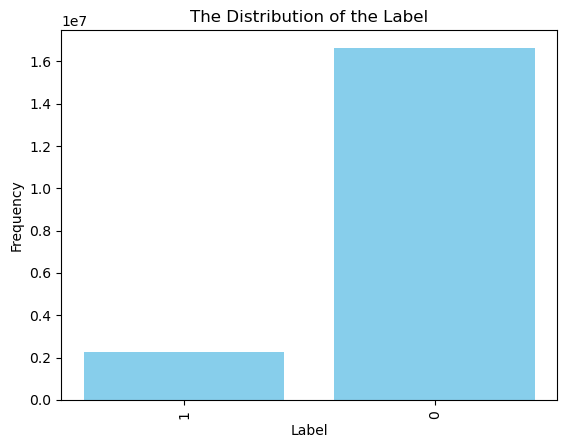

Label
0    16635567
1     2258141
Name: count, dtype: int64


In [13]:
# count how many instances exist for each unique value in the 'label' column
show_label_distribution(pd.DataFrame(df["Label"].apply(str)), "Label")

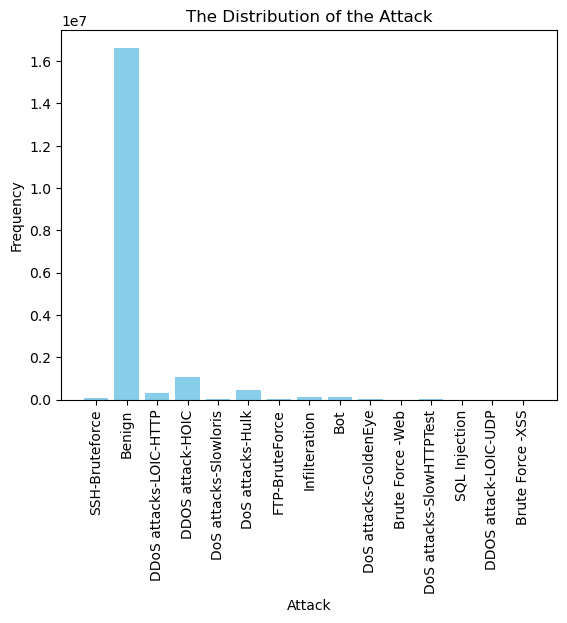

Attack
Benign                      16635567
DDOS attack-HOIC             1080858
DoS attacks-Hulk              432648
DDoS attacks-LOIC-HTTP        307300
Bot                           143097
Infilteration                 116361
SSH-Bruteforce                 94979
DoS attacks-GoldenEye          27723
FTP-BruteForce                 25933
DoS attacks-SlowHTTPTest       14116
DoS attacks-Slowloris           9512
Brute Force -Web                2143
DDOS attack-LOIC-UDP            2112
Brute Force -XSS                 927
SQL Injection                    432
Name: count, dtype: int64


In [14]:
show_label_distribution(df, "Attack")

## 4.2. Stratified Sampling by Attack Type

In [15]:
# uniform random data downsampling
# groupby and sample operations reduce the dataset by taking a 10% sample from each group defined by unique values in 'Attack' columns
# random_state is set to ensure reproducibility; it's a seed value for the random number generator used by sample()
df_reduced = df.groupby(by='Attack').sample(frac=POURCENTAGE_DATASET_REMAINING, random_state=SEED)

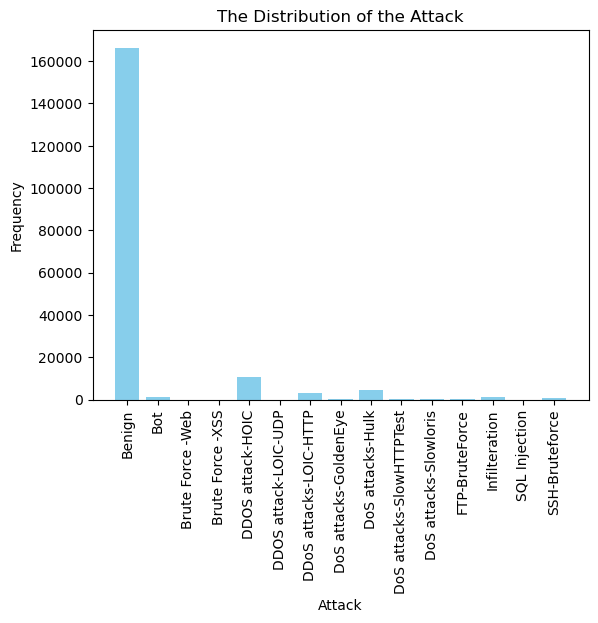

Attack
Benign                      166356
DDOS attack-HOIC             10809
DoS attacks-Hulk              4326
DDoS attacks-LOIC-HTTP        3073
Bot                           1431
Infilteration                 1164
SSH-Bruteforce                 950
DoS attacks-GoldenEye          277
FTP-BruteForce                 259
DoS attacks-SlowHTTPTest       141
DoS attacks-Slowloris           95
Brute Force -Web                21
DDOS attack-LOIC-UDP            21
Brute Force -XSS                 9
SQL Injection                    4
Name: count, dtype: int64


In [16]:
show_label_distribution(df_reduced, "Attack")

## 4.3. Rename, Delete and Convert Columns

In [17]:
# remove leading and trailind spaces from column names
df_reduced.rename(columns=lambda x: x.strip(), inplace=True)

# remove the columns L4_SRC_PORT and L4_DST_PORT from the DataFrame. 
df_reduced.drop(columns=["L4_SRC_PORT", "L4_DST_PORT"], inplace=True)

# convert columns to string format
df_reduced['IPV4_SRC_ADDR'] = df_reduced["IPV4_SRC_ADDR"].apply(str)
df_reduced['IPV4_DST_ADDR'] = df_reduced["IPV4_DST_ADDR"].apply(str)



In [18]:
# print(df_reduced.info())
df_reduced.describe()

c:\Users\helen\Documents\Concordia University\INSE 6180\project\conda_anomal_e_venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,...,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label
count,188936.000000,188936.000000,1.889360e+05,188936.000000,1.889360e+05,188936.000000,188936.000000,188936.000000,188936.000000,1.889360e+05,...,188936.000000,188936.000000,188936.000000,188936.000000,188936.000000,188936.000000,188936.000000,188936.000000,188936.0,188936.000000
mean,10.567573,12.458346,1.757979e+03,22.850653,8.790628e+03,10.860318,76.198861,75.491764,21.271976,5.743776e+05,...,5.338713,11481.456742,20866.108238,3222.631351,12.588400,13362.767085,3.941287,19.242865,0.0,0.119511
std,5.434893,28.752835,6.439726e+04,1075.185261,5.822220e+05,388.387299,99.079586,98.843107,29.069705,1.461825e+06,...,384.752339,19082.255765,24995.168361,12020.114372,46.953572,20107.399069,15.624698,26.381560,0.0,0.324390
min,1.000000,0.000000,2.800000e+01,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,6.000000,0.000000,6.800000e+01,1.000000,1.160000e+02,1.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,6.000000,0.000000,1.720000e+02,3.000000,3.180000e+02,3.000000,26.000000,26.000000,22.000000,0.000000e+00,...,0.000000,8192.000000,8192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,17.000000,7.000000,1.460000e+03,9.000000,1.873000e+03,7.000000,219.000000,219.000000,27.000000,0.000000e+00,...,1.000000,8192.000000,29200.000000,0.000000,0.000000,25225.000000,1.000000,60.000000,0.0,0.000000
max,58.000000,248.000000,7.095720e+06,118262.000000,1.021771e+08,68626.000000,223.000000,223.000000,223.000000,4.294967e+06,...,67935.000000,65535.000000,65535.000000,65280.000000,255.000000,65532.000000,255.000000,60.000000,0.0,1.000000


## 4.4. Feature and Target Matrices Generation

In [19]:
# create a new DataFrame X by removing the columns 'Attack' and 'Label' from the original df DataFrame
# X will serve as the feature matrix, which contains the df that the machine learning model will use to learn patterns
X = df_reduced.drop(columns=["Attack", "Label"])

# y is created as a new DataFrame containing only the Attack and Label columns from the original df DataFrame
# y will serve as the target or labels that the model will try to predict
y = df_reduced[["Attack", "Label"]]


## 4.5. Data Spliting into Training and Testing Sets

In [20]:

# splits df into training and testing sets
# X_train and y_train are the features and labels used for training the model
# X_test and y_test are for evaluating the model's performance
# test_size=0.3 parameter indicates that 30% of the df is reserved for testing
# stratify=y ensures that the distribution of labels in both training and testing sets is similar to the original dataset
X_train, X_test, y_train, y_test = train_test_split(
                                                X, 
                                                y, 
                                                test_size=TEST_SET_SIZE, 
                                                random_state=SEED, 
                                                stratify=y)

In [21]:
print(X_train.shape)
print(y_train)

(132255, 41)
                    Attack  Label
3652644             Benign      0
4233542             Benign      0
13462639            Benign      0
4080446             Benign      0
15857605            Benign      0
...                    ...    ...
1943347             Benign      0
17393895            Benign      0
17928622  DDOS attack-HOIC      1
5652075             Benign      0
5870306             Benign      0

[132255 rows x 2 columns]


## 4.6. Data Balancing (IMPROVEMENT 1)

### 4.6.1. Random Over Sampling

In [22]:
def balance_data_with_ros(X_train, y_train):
    """
    Balances the training data by oversampling attack samples in such a way that the total number of
    attack samples matches the number of benign samples, while maintaining the proportional distribution
    of each specific type of attack.

    Inputs:
    - X_train: DataFrame containing the features for training.
    - y_train: DataFrame containing the 'Attack' and 'Label' columns.
    
    Outputs:
    - X_train_balanced: DataFrame of features after balancing the data.
    - y_train_balanced: DataFrame of labels after balancing the data, includes both 'Attack' and 'Label' columns.
    """

    # combine X_train and y_train for ease of operation
    df_train = pd.concat([X_train, y_train], axis=1)

    # separate the data into benign and attack samples
    benign_samples = df_train[df_train['Label'] == 0]
    attack_samples = df_train[df_train['Label'] == 1]

    # determine the number of benign samples
    total_benign = benign_samples.shape[0]

    # calculate the proportional distribution of each attack type
    proportions = attack_samples['Attack'].value_counts(normalize=True)
    attack_targets = {attack: int(proportion * total_benign) for attack, proportion in proportions.items()}

    # configure RandomOverSampler to oversample attack types according to calculated targets
    ros = RandomOverSampler(sampling_strategy=attack_targets, random_state=42)
    
    # apply oversampling
    X_resampled, y_resampled = ros.fit_resample(df_train.drop(columns=['Attack', 'Label']), df_train['Attack'])
    
    # reconstruct the DataFrame after resampling
    df_resampled = pd.DataFrame(X_resampled, columns=df_train.drop(columns=['Attack', 'Label']).columns)
    df_resampled['Attack'] = y_resampled
    df_resampled['Label'] = df_resampled['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)

    # shuffle the dataset
    df_resampled = shuffle(df_resampled, random_state=42)

    # print the new distribution of attacks
    show_label_distribution(df_resampled, "Attack")
    show_label_distribution(pd.DataFrame(df_resampled["Label"].apply(str)), "Label")

    # return the balanced dataset split into features and labels
    return df_resampled.drop(columns=['Attack', 'Label']), df_resampled[['Attack', 'Label']]


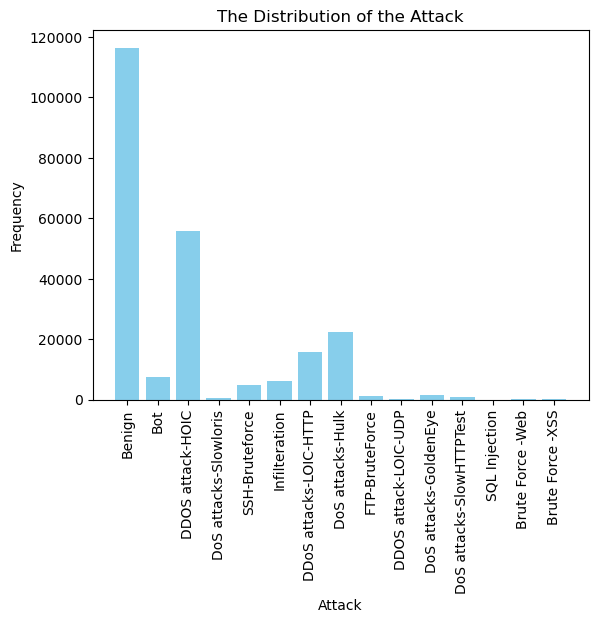

Attack
Benign                      116449
DDOS attack-HOIC             55741
DoS attacks-Hulk             22308
DDoS attacks-LOIC-HTTP       15847
Bot                           7382
Infilteration                 6004
SSH-Bruteforce                4899
DoS attacks-GoldenEye         1429
FTP-BruteForce                1333
DoS attacks-SlowHTTPTest       729
DoS attacks-Slowloris          486
DDOS attack-LOIC-UDP           110
Brute Force -Web               110
Brute Force -XSS                44
SQL Injection                   22
Name: count, dtype: int64


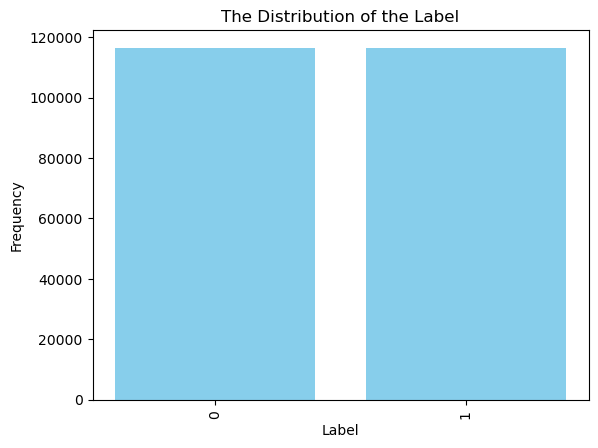

Label
0    116449
1    116444
Name: count, dtype: int64


In [23]:
# balance the dataset using the over sampling method
X_train, y_train = balance_data_with_ros(X_train, y_train)

In [24]:
print(X_train.shape)
print(y_train)

(232893, 41)
                Attack  Label
0               Benign      0
1               Benign      0
2               Benign      0
3               Benign      0
4               Benign      0
...                ...    ...
232888  SSH-Bruteforce      1
232889  SSH-Bruteforce      1
232890  SSH-Bruteforce      1
232891  SSH-Bruteforce      1
232892  SSH-Bruteforce      1

[232893 rows x 2 columns]


In [25]:
print(X_train.shape)
print(y_train)

(232893, 41)
                Attack  Label
0               Benign      0
1               Benign      0
2               Benign      0
3               Benign      0
4               Benign      0
...                ...    ...
232888  SSH-Bruteforce      1
232889  SSH-Bruteforce      1
232890  SSH-Bruteforce      1
232891  SSH-Bruteforce      1
232892  SSH-Bruteforce      1

[232893 rows x 2 columns]


### 4.6.2. Synthetic Minority Over-sampling Technique (SMOTE) 

In [81]:
def balance_data_with_smote(X_train, y_train):
    """
    Balances the training data using SMOTE to create synthetic samples for attack classes,
    ensuring the total number of attack samples matches the number of benign samples,
    while maintaining the proportional distribution of each specific type of attack.

    Inputs:
    - X_train: DataFrame containing the features for training.
    - y_train: DataFrame containing the 'Attack' and 'Label' columns.
    
    Outputs:
    - X_train_balanced: DataFrame of features after balancing the data using SMOTE.
    - y_train_balanced: DataFrame of labels after balancing the data, includes both 'Attack' and 'Label' columns.
    """
    
    # combine X_train and y_train for ease of operation
    df_train = pd.concat([X_train, y_train], axis=1)

    # separate the data into benign and attack samples
    benign_samples = df_train[df_train['Label'] == 0]
    attack_samples = df_train[df_train['Label'] == 1]

    # determine the number of benign samples
    total_benign = benign_samples.shape[0]

    # calculate the proportional distribution of each attack type
    proportions = attack_samples['Attack'].value_counts(normalize=True)
    attack_targets = {attack: int(proportion * total_benign) for attack, proportion in proportions.items()}

    # configure SMOTE to generate synthetic samples for attack types according to calculated targets
    smote = SMOTE(sampling_strategy=attack_targets, random_state=42)
    
    # apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(df_train.drop(columns=['Attack', 'Label']), df_train['Attack'])
    
    # reconstruct the DataFrame after resampling
    df_resampled = pd.DataFrame(X_resampled, columns=df_train.drop(columns=['Attack', 'Label']).columns)
    df_resampled['Attack'] = y_resampled
    df_resampled['Label'] = df_resampled['Attack'].apply(lambda x: 0 if x == 'Benign' else 1)

    # shuffle the dataset
    df_resampled = shuffle(df_resampled, random_state=42)

    # print the new distribution of attacks
    show_label_distribution(df_resampled, "Attack")
    show_label_distribution(pd.DataFrame(df_resampled["Label"].apply(str)), "Label")

    # return the balanced dataset split into features and labels
    return df_resampled.drop(columns=['Attack', 'Label']), df_resampled[['Attack', 'Label']]


In [ ]:
""" 
# data balancing with smote
X_train_balanced, y_train_balanced = balance_data_with_smote(X_train, y_train)
"""

In [ ]:
""" 
print(X_train.shape)
print(y_train)
"""

## 4.7. Categorical Feature Encoding

In [29]:
# initializes a target encoder object that will convert categorical features into numeric values 
#   based on the mean target value (from y_train.Label) for each category
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL',
                                  'CLIENT_TCP_FLAGS','SERVER_TCP_FLAGS','ICMP_TYPE',
                                  'ICMP_IPV4_TYPE','DNS_QUERY_ID','DNS_QUERY_TYPE',
                                  'FTP_COMMAND_RET_CODE'])

# fit the encoder to the training df, 
#   learning the mappings from categories to numeric values based on the target (y_train.Label)
encoder.fit(X_train, y_train.Label)

# apply the learned encoding to the training df, 
#   converting categorical columns to their numeric representations
X_train = encoder.transform(X_train)

# apply the learned encoding to the testing df
X_test = encoder.transform(X_test)

## 4.8. Data Cleaning: Handling of Infinite and Empty Values

In [30]:
# replace infinite values in the training df with NaN (Not a Number) -> to handle mathematical anomalies in the dataset 
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# replace all NaN values in the training df with 0, which is a method of handling missing values
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

## 4.9. Feature Normalization and Vectorization

In [31]:
# initialize a normalizer object that will scale the features in the df to have a unit norm (common processing step to ensure that no featues dominates due to its scale)
scaler = Normalizer()
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns))) # ignore first two as the represents IP addresses

# fit the scaler to the training df, learning the scaling parameters
scaler.fit(X_train[cols_to_norm])

Normalizer()

## 4.10. Scaling and Feature Transformation

In [32]:
# apply the learned scaling to the training df
X_train[cols_to_norm] = scaler.transform(X_train[cols_to_norm])
# create a new column h in the training df, converting the rows into lists (likely for use in a model that expects a specific df format)
X_train['h'] = X_train.iloc[:, 2:].values.tolist()

# apply the learned scaling to the testing df
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])
# create a new column h in the testing df similar to the training df
X_test['h'] = X_test.iloc[:, 2:].values.tolist()

In [33]:
print(X_train.shape)

(232893, 42)


## 4.11. Transformed Features and Original Labels Concatenation

In [34]:
# concatenate transformed features and original labels to form the final training and testing datasets

# combine the features and labels into a single DataFrame for the training df
train = pd.concat([X_train, y_train], axis=1)
# combine the features and labels into a single DataFrame for the testing df
test = pd.concat([X_test, y_test], axis=1)

In [35]:
# displays the first few rows of the training df set to get a preview of the df
#X_train.head()

## 4.12. Feature Selection using XGBoost

In [36]:
def process_data_xgboost(X_train, X_test, y_train, y_test):
    # Drop specific columns from training and testing data
    xg_xtrain = X_train.copy()
    xg_xtrain.drop(columns=['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'h'], inplace=True)
    xg_xtest = X_test.copy()
    xg_xtest.drop(columns=['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'h'], inplace=True)

    # Custom XGBClassifier to store feature names
    class XGBClassifierWithNames(XGBClassifier):
        def fit(self, X, y):
            self.feature_names = X.columns.tolist()
            super().fit(X, y)

    # Fit the model
    model = XGBClassifierWithNames()
    model.fit(xg_xtrain, y_train['Label'])

    # print("Feature names:", model.feature_names)
    
    # Feature importance and selection
    thresholds = sort(model.feature_importances_)
    print(thresholds)
    selection = SelectFromModel(model, threshold=2.3209294e-03, prefit=True, max_features=100)
    X_train_selected = pd.DataFrame(selection.transform(xg_xtrain), columns=xg_xtrain.columns[selection.get_support()])
    X_test_selected = pd.DataFrame(selection.transform(xg_xtest), columns=xg_xtest.columns[selection.get_support()])

    # Create subsets of features from training and test sets
    X_first_subset = X_train.iloc[:, :2].copy()
    X_second_subset = X_train_selected.copy()
    X_first_subset.reset_index(drop=True, inplace=True)
    X_second_subset.reset_index(drop=True, inplace=True) 
    X_train = pd.concat([X_first_subset, X_second_subset], axis=1)
    X_train['h'] = X_train.iloc[:, 2:].values.tolist()

    # Print shapes for debugging
    print(X_first_subset.columns)
    print(X_second_subset.columns)
    print(y_train.shape)

    # Repeat the process for the testing data
    X_first_subset = X_test.iloc[:, :2].copy()
    X_second_subset = X_test_selected.copy()
    X_first_subset.reset_index(drop=True, inplace=True)
    X_second_subset.reset_index(drop=True, inplace=True) 
    X_test = pd.concat([X_first_subset, X_second_subset], axis=1)
    X_test['h'] = X_test.iloc[:, 2:].values.tolist()

    # Reset indices before concatenation
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    # Concatenate features and labels
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)

    return train, test

In [37]:
# do feature selection with XGBoost
# train, test = process_data_xgboost(X_train, X_test, y_train, y_test)

In [38]:
# print(X_train.shape)

## 4.13. Encoding Target Variable 'Attack' for Model Input

In [39]:
# convert the target variable Attack into numeric codes

# initialize of label encoder
lab_enc = preprocessing.LabelEncoder()
# fit the encoder to the target variable "Attack"
lab_enc.fit(df["Attack"])

# convert the categorical labels in the Attack column of the train dataframe into the numeric codes learned during the fitting process
train["Attack"] = lab_enc.transform(train["Attack"])

# convert the categorical labels in the Attack column of the test dataframe into the numeric codes learned during the fitting process
test["Attack"] = lab_enc.transform(test["Attack"])

# 5. Graph Initialisation

In [40]:
# Training graph

train_g = nx.from_pandas_edgelist(train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR",
            ["h", "Label", "Attack"], create_using=nx.MultiGraph())

train_g = train_g.to_directed()
train_g = dgl.from_networkx(train_g, edge_attrs=['h', 'Attack', 'Label'])

train_g = train_g.to(device)  # Move graph to GPU

nfeat_weight = torch.ones([train_g.number_of_nodes(), train_g.edata['h'].shape[1]], device=device)
train_g.ndata['h'] = nfeat_weight

In [41]:
# Testing graph

test_g = nx.from_pandas_edgelist(test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR",
            ["h", "Label", "Attack"], create_using=nx.MultiGraph())

test_g = test_g.to_directed()
test_g = dgl.from_networkx(test_g, edge_attrs=['h', 'Attack', 'Label'])
test_g = test_g.to(device)  # Move graph to GPU
nfeat_weight = torch.ones([test_g.number_of_nodes(), test_g.edata['h'].shape[1]], device=device)
test_g.ndata['h'] = nfeat_weight

# 6. Model Training

## 6.1. Model Initialisation

### 6.1.1. Hyperparameter values used in Anomal-E

In [42]:
ndim_in = train_g.ndata['h'].shape[1]
num_layers = 1
hidden_features = 128  # though the paper says 256
learning_rate = 1e-3
ndim_out = 128
edim = train_g.edata['h'].shape[1]
epochs = 4000

### 6.1.2. DGI Initialization

In [43]:
dgi = DGI(ndim_in, 
          ndim_out, 
          edim, 
          F.relu)

dgi = dgi.to(device)  # Move the model to the device (GPU)

dgi_optimizer = torch.optim.Adam(dgi.parameters(),
                                lr=learning_rate,
                                weight_decay=0.)

### 6.1.2. Format node and edge features for E-GraphSAGE

In [44]:
train_g.ndata['h'] = torch.reshape(train_g.ndata['h'],
                                   (train_g.ndata['h'].shape[0], 1,
                                    train_g.ndata['h'].shape[1])).to(device)

train_g.edata['h'] = torch.reshape(train_g.edata['h'],
                                   (train_g.edata['h'].shape[0], 1,
                                    train_g.edata['h'].shape[1])).to(device)

## 6.2. Training loop

In [45]:
cnt_wait = 0
best = 1e9
best_t = 0
dur = []
node_features = train_g.ndata['h']
edge_features = train_g.edata['h']

In [46]:
def train_model(epochs, dgi, train_g, node_features, edge_features, dgi_optimizer, best=float('inf'), best_t=0, cnt_wait=0, dur=[]):
    """
    Train a model over a specified number of epochs and update its parameters.

    Parameters:
    - epochs (int): Number of epochs to train.
    - dgi (torch.nn.Module): The model to train.
    - train_g (DGLGraph): The graph data.
    - node_features (Tensor): Features of the nodes.
    - edge_features (Tensor): Features of the edges.
    - dgi_optimizer (torch.optim.Optimizer): Optimizer for the model.
    - best (float): The best loss value encountered during training.
    - best_t (int): The epoch number with the best loss.
    - cnt_wait (int): Counter for patience in early stopping logic.
    - dur (list): List to accumulate epoch durations.

    Returns:
    - best (float): Best loss achieved.
    - best_t (int): Epoch of the best loss.
    - model_path (str): Path to the saved model.
    - losses (list): List of loss values per epoch.
    """
    losses = []  # Initialize list to store loss values
    for epoch in range(epochs):
        dgi.train()  # Set model to training mode
        if epoch >= 3:
            t0 = time.time()

        dgi_optimizer.zero_grad()
        loss = dgi(train_g, node_features, edge_features)
        loss.backward()
        dgi_optimizer.step()
        losses.append(loss.item())  # Record the loss for this epoch

        if loss < best:
            best = loss
            best_t = epoch
            cnt_wait = 0
            model_path = 'best_dgi.pkl'
            torch.save(dgi.state_dict(), model_path)
        else:
            cnt_wait += 1

        # Uncomment to enable early stopping
        # if cnt_wait == patience:
        #     print('Early stopping!')
        #     break

        if epoch >= 3:
            dur.append(time.time() - t0)

        if epoch % 50 == 0:
            print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | ETputs(KTEPS) {:.2f}".format(
                epoch, np.mean(dur), loss.item(), train_g.num_edges() / np.mean(dur) / 1000))

    return best, best_t, model_path, losses


In [47]:
# plot loss function
def plot_losses(losses):
    """
    Plot the training losses over epochs.

    Parameters:
    - losses (list): A list of loss values recorded over training epochs.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


**_Train the model below!_**

In [48]:
best, best_t, model_path, losses = train_model(epochs, 
                                               dgi, 
                                               train_g, 
                                               node_features, 
                                               edge_features, 
                                               dgi_optimizer, 
                                               best, 
                                               best_t, 
                                               cnt_wait, 
                                               dur)


c:\Users\helen\Documents\Concordia University\INSE 6180\project\conda_anomal_e_venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\helen\Documents\Concordia University\INSE 6180\project\conda_anomal_e_venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Loss 1.4190 | ETputs(KTEPS) nan
Epoch 00050 | Time(s) 0.2510 | Loss 1.2149 | ETputs(KTEPS) 1854.67
Epoch 00100 | Time(s) 0.2513 | Loss 0.1458 | ETputs(KTEPS) 1852.10
Epoch 00150 | Time(s) 0.2513 | Loss 0.0817 | ETputs(KTEPS) 1851.96
Epoch 00200 | Time(s) 0.2509 | Loss 0.0609 | ETputs(KTEPS) 1854.87
Epoch 00250 | Time(s) 0.2507 | Loss 0.0509 | ETputs(KTEPS) 1856.52
Epoch 00300 | Time(s) 0.2503 | Loss 0.0448 | ETputs(KTEPS) 1859.75
Epoch 00350 | Time(s) 0.2492 | Loss 0.0388 | ETputs(KTEPS) 1867.69
Epoch 00400 | Time(s) 0.2485 | Loss 0.0328 | ETputs(KTEPS) 1873.16
Epoch 00450 | Time(s) 0.2479 | Loss 0.0286 | ETputs(KTEPS) 1877.90
Epoch 00500 | Time(s) 0.2474 | Loss 0.0260 | ETputs(KTEPS) 1881.07
Epoch 00550 | Time(s) 0.2470 | Loss 0.0228 | ETputs(KTEPS) 1884.16
Epoch 00600 | Time(s) 0.2467 | Loss 0.0213 | ETputs(KTEPS) 1886.45
Epoch 00650 | Time(s) 0.2465 | Loss 0.0202 | ETputs(KTEPS) 1888.58
Epoch 00700 | Time(s) 0.2462 | Loss 0.0195 | ETputs(KTEPS) 1890.58
Ep

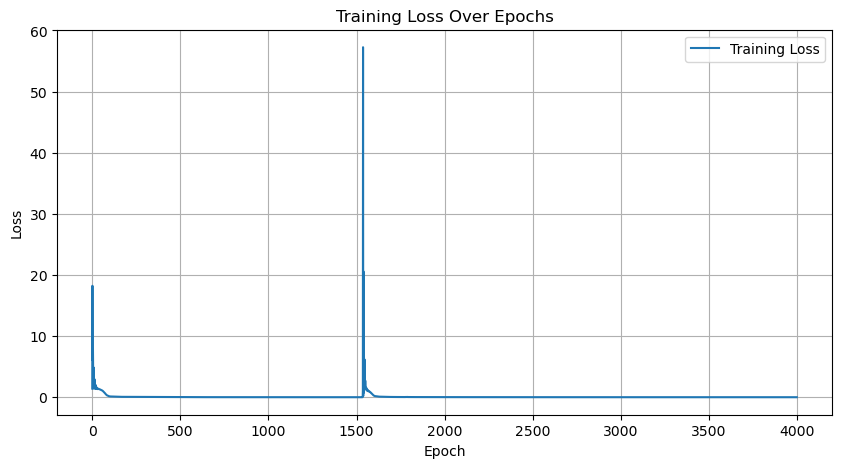

In [49]:
# now plotting the loss curve
plot_losses(losses)

In [50]:
print("best loss", best)
print("best loss time", best_t)

best loss tensor(0.0095, device='cuda:0', grad_fn=<AddBackward0>)
best loss time 3991


# 7. Post training

## 7.1. Load the Best Model

In [51]:
dgi.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

## 7.2. Processing Training Data

In [52]:
## Get embeddings from the model, detach from the computation graph, and move to CPU for further processing
training_emb = dgi.encoder(train_g.to(device), 
                           train_g.ndata['h'].to(device), 
                           train_g.edata['h'].to(device))[1]

training_emb = training_emb.detach().cpu().numpy()

## 7.3. Reshape Features for Testing

In [53]:
# Before predicting the test set, reshape the features to match the input requirement of the model
test_g.ndata['h'] = torch.reshape(test_g.ndata['h'], 
                                  (test_g.ndata['h'].shape[0], 1, 
                                   test_g.ndata['h'].shape[1])).to(device)

test_g.edata['h'] = torch.reshape(test_g.edata['h'], 
                                  (test_g.edata['h'].shape[0], 1, 
                                   test_g.edata['h'].shape[1])).to(device)


## 7.4. Process Testing Data

In [54]:
## Get embeddings for the test graph, similar to the training graph
testing_emb = dgi.encoder(test_g, test_g.ndata['h'], test_g.edata['h'])[1]
testing_emb = testing_emb.detach().cpu().numpy()

## 7.5. Prepare DataFrame for Training Results

In [55]:
## Create a DataFrame for training embeddings and add labels and attack types
df_train = pd.DataFrame(training_emb)
df_train["Attack"] = lab_enc.inverse_transform(train_g.edata['Attack'].detach().cpu().numpy())
df_train["Label"] = train_g.edata['Label'].detach().cpu().numpy()

## 7.6. Prepare DataFrame for Testing Result

In [56]:
## Similar to the training DataFrame, create one for the test embeddings
df_test = pd.DataFrame(testing_emb)
df_test["Attack"] = lab_enc.inverse_transform(test_g.edata['Attack'].detach().cpu().numpy())
df_test["Label"] = test_g.edata['Label'].detach().cpu().numpy()


## 7.8. Display Training DataFrame

In [57]:
## This is useful to see the outputs right after processing the data
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,Attack,Label
0,0.025301,-0.019971,-0.02902,-0.052693,-0.014652,0.028321,-0.049849,-0.044027,0.057083,-0.004885,...,-0.000599,-0.026778,-0.040787,0.041699,0.042118,0.050101,0.000171,-0.00573,Benign,0
1,0.025301,-0.019971,-0.02902,-0.052693,-0.014652,0.028321,-0.049849,-0.044027,0.057083,-0.004885,...,-0.000599,-0.026778,-0.040787,0.041699,0.042118,0.050101,0.000171,-0.00573,Benign,0
2,0.025301,-0.019971,-0.02902,-0.052693,-0.014652,0.028321,-0.049849,-0.044027,0.057083,-0.004885,...,-0.000599,-0.026778,-0.040787,0.041699,0.042118,0.050101,0.000171,-0.00573,Benign,0
3,0.025301,-0.019971,-0.02902,-0.052693,-0.014652,0.028321,-0.049849,-0.044027,0.057083,-0.004885,...,-0.000599,-0.026778,-0.040787,0.041699,0.042118,0.050101,0.000171,-0.00573,Benign,0
4,0.025301,-0.019971,-0.02902,-0.052693,-0.014652,0.028321,-0.049849,-0.044027,0.057083,-0.004885,...,-0.000599,-0.026778,-0.040787,0.041699,0.042118,0.050101,0.000171,-0.00573,Benign,0


# 8. Anomaly Detection

## 8.1. Train and Test Samples

In [58]:
# benign train samples ()
benign_train_samples = df_train[df_train.Label == 0].drop(columns=["Label", "Attack"])
normal_train_samples = df_train.drop(columns=["Label", "Attack"])

train_labels = df_train["Label"]
test_labels = df_test["Label"]

test_samples = df_test.drop(columns=["Label", "Attack"])

## 8.2. Hyperparameters values used in grid search for classification models

### 8.2.1. Contamination Level

In [59]:
# contamination is supposed to be the percentage of attacks in the set
# if it's only benign samples, there is no attack

contamination = [0.001, 0.01, 0.04, 0.05, 0.1, 0.2, 0.5, 0.6, 0.7]

### 8.2.2. Hyperparameters specific to each model

In [78]:
n_clusters = [2, 3, 5, 7, 9, 10, 14, 17, 20, 25, 30, 40, 50, 100]  # CBLOF number of clusters 
n_bins = [5, 10, 15, 20, 25, 30]  # HBOS number of bins 
n_components = [5, 10, 15, 20, 25, 30]  # PCA number of components
n_estimators = [20, 50, 100, 150]  # IF number of estimators 


## 8.3. Classification Models

### 8.3.1. Cluster-Based Local Outlier Factor (CBLOF) Model

In [61]:
# determine the best configuration for a CBLOF model based on F1 score performance

def find_best_cblof_parameters(n_clusters, contamination, train_samples, test_samples, test_labels):
    """
    Determine the best parameters for the CBLOF model based on F1 score.

    Parameters:
    - n_estimators (list): List of n_clusters values to try.
    - contamination (list): List of contamination fraction values to try.
    - train_samples (DataFrame): Training data samples.
    - test_samples (DataFrame): Testing data samples.
    - test_labels (Series): True labels for the test data.

    Returns:
    - best_params (dict): Dictionary containing the best parameters.
    - score (float): Best F1 score achieved.
    - best_classification_report (str): Classification report for the best parameters.
    """
    params = list(itertools.product(n_clusters, contamination))
    score = -1
    best_classification_report = None
    bs = None
    best_params = None

    for n_cluster, con in tqdm(params):
        clf_if = CBLOF(n_clusters=n_cluster, contamination=con)
        clf_if.fit(train_samples)
        y_pred = clf_if.predict(test_samples)
        test_pred = y_pred

        f1 = f1_score(test_labels, test_pred, average='macro')

        if f1 > score:
            score = f1
            best_params = {'n_clusters': n_cluster, "contamination": con}
            bs = test_pred
            best_classification_report = classification_report(test_labels, test_pred, digits=4)
        
        del clf_if
        gc.collect()

    return best_params, score, best_classification_report


#### 8.3.1.1. Results with Benign Train Samples

In [82]:
""" 
# call the function:
best_params, best_score, best_report = find_best_cblof_parameters(
    n_clusters, contamination, benign_train_samples, test_samples, test_labels)

# output the results:
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)
print("Best Classification Report:\n", best_report)

"""

' \n# call the function:\nbest_params, best_score, best_report = find_best_cblof_parameters(\n    n_clusters, contamination, benign_train_samples, test_samples, test_labels)\n\n# output the results:\nprint("Best Parameters:", best_params)\nprint("Best F1 Score:", best_score)\nprint("Best Classification Report:\n", best_report)\n\n'

#### 8.3.1.2. Results with Normal Train Samples (with Attack Samples)

In [67]:

# call the function:
best_params, best_score, best_report = find_best_cblof_parameters(
    n_estimators, contamination, normal_train_samples, test_samples, test_labels)

# output the results:
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)
print("Best Classification Report:\n", best_report)



100%|██████████| 24/24 [18:24<00:00, 46.04s/it] 

Best Parameters: {'n_clusters': 20, 'contamination': 0.04}
Best F1 Score: 0.5119702368757941
Best Classification Report:
               precision    recall  f1-score   support

           0     0.8842    0.9765    0.9281     99650
           1     0.2549    0.0590    0.0959     13548

    accuracy                         0.8667    113198
   macro avg     0.5695    0.5178    0.5120    113198
weighted avg     0.8089    0.8667    0.8285    113198



### 8.3.2 Histagram-based Outlier Detection (HBOS) Model

In [68]:
# fit a HBOS model, evaluate it, and find the best configuration based on the F1 score

def find_best_hbos_parameters(n_bins, contamination, train_samples, test_samples, test_labels):
    """
    Determine the best parameters for the HBOS model based on F1 score.

    Parameters:
    - n_bins (list): List of n_bins values to try.
    - contamination (list): List of contamination fraction values to try.
    - train_samples (DataFrame): Training data samples.
    - test_samples (DataFrame): Testing data samples.
    - test_labels (Series): True labels for the test data.

    Returns:
    - best_params (dict): Dictionary containing the best parameters.
    - score (float): Best F1 score achieved.
    - best_classification_report (str): Classification report for the best parameters.
    """
    params = list(itertools.product(n_bins, contamination))
    score = -1
    best_classification_report = None
    bs = None
    best_params = None

    for n_bin, con in tqdm(params):
        clf_if = HBOS(n_bins=n_bin, contamination=con)
        clf_if.fit(train_samples)
        y_pred = clf_if.predict(test_samples)
        test_pred = y_pred

        f1 = f1_score(test_labels, test_pred, average='macro')

        if f1 > score:
            score = f1
            best_params = {'n_bins': n_bin, "contamination": con}
            bs = test_pred
            best_classification_report = classification_report(test_labels, test_pred, digits=4)
        
        del clf_if
        gc.collect()

    return best_params, score, best_classification_report


#### 8.3.2.1. Results with Benign Train Samples

In [69]:
# call the function:
best_params, best_score, best_report = find_best_hbos_parameters(
    n_bins, contamination, benign_train_samples, test_samples, test_labels)

# output the results:
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)
print("Best Classification Report:\n", best_report)

100%|██████████| 36/36 [02:59<00:00,  4.99s/it]

Best Parameters: {'n_bins': 25, 'contamination': 0.01}
Best F1 Score: 0.9405781421717173
Best Classification Report:
               precision    recall  f1-score   support

           0     0.9837    0.9884    0.9860     99650
           1     0.9117    0.8792    0.8951     13548

    accuracy                         0.9753    113198
   macro avg     0.9477    0.9338    0.9406    113198
weighted avg     0.9750    0.9753    0.9752    113198



#### 8.3.2.2. Results with Normal Train Samples

In [70]:
# call the function:
best_params, best_score, best_report = find_best_hbos_parameters(
    n_bins, contamination, normal_train_samples, test_samples, test_labels)

# output the results:
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)
print("Best Classification Report:\n", best_report)

100%|██████████| 36/36 [07:51<00:00, 13.09s/it]

Best Parameters: {'n_bins': 5, 'contamination': 0.2}
Best F1 Score: 0.7054789317819768
Best Classification Report:
               precision    recall  f1-score   support

           0     0.9233    0.9527    0.9377     99650
           1     0.5455    0.4178    0.4732     13548

    accuracy                         0.8887    113198
   macro avg     0.7344    0.6853    0.7055    113198
weighted avg     0.8781    0.8887    0.8822    113198



### 8.3.3. Principal Component Analysis (PCA) Model

In [71]:
def find_best_pca_parameters(n_components, contamination_levels, train_samples, test_samples, test_labels):
    """
    Determine the best parameters for the PCA model based on F1 score.

    Parameters:
    - n_components (list): List of n_components values to try.
    - contamination_levels (list): List of contamination fraction values to try.
    - train_samples (DataFrame): Training data samples.
    - test_samples (DataFrame): Testing data samples.
    - test_labels (Series): True labels for the test data.

    Returns:
    - best_params (dict): Dictionary containing the best parameters.
    - score (float): Best F1 score achieved.
    - best_classification_report (str): Classification report for the best parameters.
    """
    params = list(itertools.product(n_components, contamination_levels))
    score = -1
    best_classification_report = None
    bs = None
    best_params = None

    for n_component, con in tqdm(params):
        clf_if = PCA(n_components=n_component, contamination=con)
        clf_if.fit(train_samples)
        y_pred = clf_if.predict(test_samples)
        test_pred = y_pred

        f1 = f1_score(test_labels, test_pred, average='macro')

        if f1 > score:
            score = f1
            best_params = {'n_components': n_component, "contamination": con}
            bs = test_pred
            best_classification_report = classification_report(test_labels, test_pred, digits=4)
        
        del clf_if
        gc.collect()

    return best_params, score, best_classification_report


#### 8.3.3.1. Results with Benign Train Samples

In [72]:
# call the function
best_params, best_score, best_report = find_best_pca_parameters(
    n_components, contamination, benign_train_samples, test_samples, test_labels)

# output the results
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)
print("Best Classification Report:\n", best_report)

100%|██████████| 36/36 [01:40<00:00,  2.78s/it]

Best Parameters: {'n_components': 5, 'contamination': 0.01}
Best F1 Score: 0.9405974979356783
Best Classification Report:
               precision    recall  f1-score   support

           0     0.9837    0.9884    0.9860     99650
           1     0.9117    0.8792    0.8952     13548

    accuracy                         0.9754    113198
   macro avg     0.9477    0.9338    0.9406    113198
weighted avg     0.9750    0.9754    0.9752    113198



#### 8.3.3.2. Results with Normal Train Samples

In [73]:
# call the function
best_params, best_score, best_report = find_best_pca_parameters(
    n_components, contamination, normal_train_samples, test_samples, test_labels)

# output the results
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)
print("Best Classification Report:\n", best_report)

100%|██████████| 36/36 [07:18<00:00, 12.17s/it]

Best Parameters: {'n_components': 25, 'contamination': 0.2}
Best F1 Score: 0.5337901112248085
Best Classification Report:
               precision    recall  f1-score   support

           0     0.8872    0.9703    0.9269     99650
           1     0.2970    0.0922    0.1407     13548

    accuracy                         0.8652    113198
   macro avg     0.5921    0.5313    0.5338    113198
weighted avg     0.8165    0.8652    0.8328    113198



### 8.3.4. Isolation Forest (IF) Model

In [74]:
def find_best_isolation_forest_parameters(n_estimators, contamination_levels, train_samples, test_samples, test_labels):
    """
    Determine the best parameters for the Isolation Forest model based on F1 score.

    Parameters:
    - n_estimators (list): List of the number of estimators to try.
    - contamination_levels (list): List of contamination fraction values to try.
    - train_samples (DataFrame): Training data samples.
    - test_samples (DataFrame): Testing data samples.
    - test_labels (Series): True labels for the test data.

    Returns:
    - best_params (dict): Dictionary containing the best parameters.
    - score (float): Best F1 score achieved.
    - best_classification_report (str): Classification report for the best parameters.
    """
    params = list(itertools.product(n_estimators, contamination_levels))
    score = -1
    best_classification_report = None
    bs = None
    best_params = None

    for n_estimator, con in tqdm(params):
        clf_if = IsolationForest(n_estimators=n_estimator, contamination=con)
        clf_if.fit(train_samples)
        y_pred = clf_if.predict(test_samples)
        # Convert labels from -1 (outlier) and 1 (inlier) to 0 and 1
        test_pred = list(map(lambda x: 0 if x == 1 else 1, y_pred))

        f1 = f1_score(test_labels, test_pred, average='macro')

        if f1 > score:
            score = f1
            best_params = {'n_estimators': n_estimator, "contamination": con}
            bs = test_pred
            best_classification_report = classification_report(test_labels, test_pred, digits=4)
        
        del clf_if
        gc.collect()

    return best_params, score, best_classification_report


In [75]:
# define the range of n_estimators
n_estimators = [20, 50, 100, 150]


#### 8.3.4.1. Results with Benign Train Samples

In [76]:
# Call the function:
best_params, best_score, best_report = find_best_isolation_forest_parameters(
    n_estimators, contamination, benign_train_samples, test_samples, test_labels)

# Output the results:
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)
print("Best Classification Report:\n", best_report)

100%|██████████| 24/24 [01:04<00:00,  2.70s/it]

Best Parameters: {'n_estimators': 20, 'contamination': 0.01}
Best F1 Score: 0.9424306331690888
Best Classification Report:
               precision    recall  f1-score   support

           0     0.9845    0.9884    0.9864     99650
           1     0.9118    0.8854    0.8984     13548

    accuracy                         0.9760    113198
   macro avg     0.9482    0.9369    0.9424    113198
weighted avg     0.9758    0.9760    0.9759    113198



#### 8.3.4.2. Results with Normal Train Samples

In [77]:
# Call the function:
best_params, best_score, best_report = find_best_isolation_forest_parameters(
    n_estimators, contamination, normal_train_samples, test_samples, test_labels)

# Output the results:
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)
print("Best Classification Report:\n", best_report)

100%|██████████| 24/24 [02:11<00:00,  5.48s/it]

Best Parameters: {'n_estimators': 100, 'contamination': 0.2}
Best F1 Score: 0.6537917008332012
Best Classification Report:
               precision    recall  f1-score   support

           0     0.9168    0.9189    0.9178     99650
           1     0.3931    0.3865    0.3898     13548

    accuracy                         0.8552    113198
   macro avg     0.6549    0.6527    0.6538    113198
weighted avg     0.8541    0.8552    0.8546    113198

